# Introduction

Précédemment, nous avions recherché des motifs fréquents et règles d'associations importantes (lift supérieur à 1) plantes-insectes à partir des taxons présents dans la base du SPIPOLL : taxons _sc, _fr, _precision. 

En l'absence de résultats biologiquement intéressants (hormis quelques exceptions de résultats déjà connus : motifs fréquent frelons-lierre), nous avons relancé une recherche à des niveaux de taxonomies plus hauts. Pas de conclusions biologiquement pertinentes non plus. 

On s'intéresse ici à la prédation qu'avait évoquée Louis, entre les frelons européens et asiatiques. On utilise une approche de cluster par densité pour tenter de mettre en évidence ces zones où les frelons asiatiques sont davantage concentrés et "concurrencent" les frelons européens.

# Chargement des données

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./spipoll.csv")

C:\Users\guilts0300\AppData\Local\Temp\ipykernel_16644\35506862.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./spipoll.csv")


## Nettoyage

In [3]:
unused_columns = ['collection_nom', 'collection_id', 'protocole_long', 'user_id',
       'photo_fleur', 'photo_plante', 'photo_feuille',               
       'plante_caractere', 'plante_inconnue',
       'photo_fleur', 'photo_plante', 'photo_feuille',
       'code_postal', 'fleur_ombre', 
       'insecte_abondance', 'insecte_commentaire', 'insecte_vu_sur_fleur',
        'grande_culture',
       'nb_validation', 'nb_suggestion']

In [4]:
df.drop(columns=unused_columns, inplace=True)

In [5]:
# Transformation de la variable habitat

# One hot encoding après création de nouvelles colonnes pour chacun des habitats spécifiés entre ','
#habitat_dummies = df['habitat'].str.get_dummies(',')

# Concaténation les colonnes de dummies avec le DataFrame d'origine
#df = pd.concat([df, habitat_dummies], axis=1)

In [6]:
df.drop(columns=['habitat'], inplace=True)

In [7]:
# Séparation de la colonne 'coordonnées' en deux colonnes 'longitude' et 'latitude'
df[['longitude', 'latitude']] = df['coordonnees_GPS'].str.split(',', expand=True).astype(float)

In [8]:
df.drop(columns=['coordonnees_GPS'], inplace=True)

In [9]:
df.columns

Index(['plante_famille', 'plante_genre', 'plante_espece', 'plante_sc',
       'plante_fr', 'plante_precision', 'collection_date',
       'collection_heure_debut', 'nebulosite', 'temperature', 'vent',
       'insecte_ordre', 'insecte_super_famille', 'insecte_famille',
       'insecte_sous_famille', 'insecte_genre', 'insecte_espece', 'insecte_sc',
       'insecte_fr', 'insecte_denominationPlusPrecise', 'insecte_CdNomtaxref',
       'longitude', 'latitude'],
      dtype='object')

## Filtrage des coordonnées pour la France métropolitaine

In [268]:
import geopandas as gpd
from shapely.geometry import Point, Polygon


# Coordonnées approximatives des coins supérieurs gauche et inférieur droit de la France métropolitaine
bbox_france = (-5.15, 42.19, 9.325, 51.065)  # (longitude_min, latitude_min, longitude_max, latitude_max)

# Créer une géométrie représentant la France métropolitaine
france_polygon = Polygon([(bbox_france[0], bbox_france[1]), (bbox_france[2], bbox_france[1]), 
                          (bbox_france[2], bbox_france[3]), (bbox_france[0], bbox_france[3])])

# Créer un GeoDataFrame avec une seule ligne contenant la géométrie de la France métropolitaine
france_gdf = gpd.GeoDataFrame({'geometry': [france_polygon]}, crs='EPSG:4326')

# Créer une colonne 'geometry' dans votre DataFrame à partir des colonnes 'longitude' et 'latitude'
data['geometry'] = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]

# Convertir le DataFrame en un GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Filtrer les coordonnées GPS qui se situent en France métropolitaine
coordonnees_france = gdf[gdf.geometry.within(france_polygon)]

# Réinitialiser l'index si nécessaire
coordonnees_france.reset_index(drop=True, inplace=True)


# Prédation frelons européens et asiatiques ? 

## Préparation

In [10]:
# Selection des lignes d'observations de frelons asiatiques et européens 
data_frelons = df.where(df['insecte_sc'].isin(['Vespa velutina', 'Vespa crabro'])).dropna(subset=['insecte_sc'])

In [11]:
data_frelons.shape

(1663, 23)

In [12]:
# Nettoyage des colonnes inutiles à l'analyse
to_drop = [  'insecte_ordre', 'insecte_super_famille', 'insecte_famille',
       'insecte_sous_famille', 'insecte_genre', 'insecte_espece',
            'insecte_sc', 'insecte_denominationPlusPrecise', 'insecte_CdNomtaxref',
           'plante_famille', 'plante_genre', 'plante_espece', 'plante_sc',
       'plante_fr', 'plante_precision', 
           'nebulosite', 'temperature', 'vent', 'collection_heure_debut']

In [13]:
data_frelons.drop(columns=to_drop, inplace = True)

In [14]:
data_frelons

,collection_date,insecte_fr,longitude,latitude
1005,2019-02-27,Le Frelon asiatique,48.840296,2.318376
1273,2019-03-03,Le Frelon asiatique,44.849311,-0.576464
4034,2019-03-31,Le Frelon asiatique,45.002003,1.025581
4321,2019-03-29,Le Frelon asiatique,48.019447,-1.647089
5041,2019-04-07,Le Frelon asiatique,48.091839,-1.674433
...,...,...,...,...
669241,2023-10-22,Le Frelon asiatique,48.692419,-1.954558
669531,2023-09-17,Le Frelon asiatique,48.790439,2.457470
670190,2022-08-06,Le Frelon européen,45.528658,2.977738
670397,2023-11-07,Le Frelon asiatique,48.218104,-1.693990


## DBSCAN

In [15]:
from sklearn.cluster import DBSCAN
import pandas as pd

# Créer un DataFrame avec uniquement les coordonnées GPS
coordonnees_gps = data_frelons[['latitude', 'longitude']]

# Instancier et entraîner le modèle DBSCAN
epsilon = 0.1  # Rayon maximal pour considérer les points voisins
min_samples = 10  # Nombre minimal de points dans un cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(coordonnees_gps)

# Ajouter les labels de cluster au DataFrame d'origine
data_frelons['cluster_label'] = dbscan.labels_

# Filtrer les données pour exclure les points considérés comme du bruit (cluster_label = -1)
df_clusters = data_frelons[data_frelons['cluster_label'] != -1]

# Calculer la latitude et la longitude moyennes de chaque cluster
cluster_coords = df_clusters.groupby('cluster_label').agg({'latitude': 'mean', 'longitude': 'mean'})

# Calculer le nombre total d'insectes par cluster
total_insectes_par_cluster = df_clusters.groupby('cluster_label')['insecte_fr'].count()

# Calculer la proportion de chaque type d'insecte par cluster
proportion_par_cluster = df_clusters.groupby(['cluster_label', 'insecte_fr']).size() / total_insectes_par_cluster
proportion_par_cluster = proportion_par_cluster.reset_index(name='proportion')

# Afficher les régions endémiques avec la proportion de chaque type d'insecte
regions_frelons = proportion_par_cluster.pivot(index='cluster_label', columns='insecte_fr', values='proportion').fillna(0)

# Ajouter les coordonnées de chaque cluster au DataFrame des régions endémiques
regions_frelons[['latitude', 'longitude']] = cluster_coords

print("Nombre de clusters : ", len(regions_frelons))

Nombre de clusters :  33


In [16]:
# Sortie visuelle 

import folium

# Coordonnées géographiques de centrage
latitude_mean = data_frelons['latitude'].mean()
longitude_mean = data_frelons['longitude'].mean()

# Création de la carte Folium centrée sur les données
carte = folium.Map(location=[longitude_mean, latitude_mean], zoom_start=6)

# Ajouter des marqueurs pour chaque région endémique identifiée
for i, region in regions_frelons.iterrows():
    latitude = region['latitude']
    longitude = region['longitude']
    proportion_frelons_asiat = region['Le Frelon asiatique']
    
    # Définir la couleur du marqueur en fonction de la proportion de frelons asiatiques
    if proportion_frelons_asiat >= 0.75:
        couleur_marqueur = 'darkred'
    elif proportion_frelons_asiat >= 0.5:
        couleur_marqueur = 'red'
    elif proportion_frelons_asiat >= 0.25:
        couleur_marqueur = 'blue'
    else:
        couleur_marqueur = 'lightblue'

    
    popup_text = f"Cluster de frelons : Proportion de frelons asiatiques = {proportion_frelons_asiat:.2f}"
    folium.Marker([longitude, latitude], popup=popup_text, icon=folium.Icon(color=couleur_marqueur)).add_to(carte)

# Afficher la carte
carte.save('carte_frelons.html')


In [18]:
carte

### Affinage de epsilon et min_sample

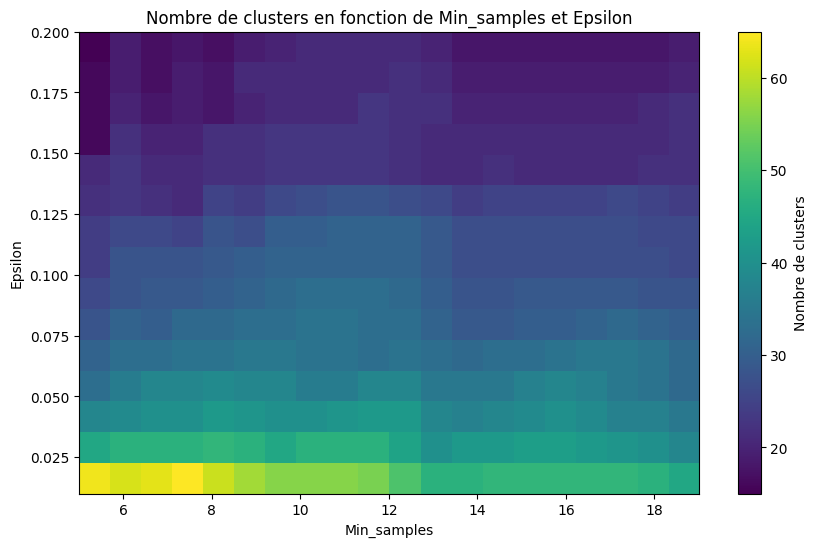

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Définir une plage de valeurs pour min_samples et epsilon
min_samples_range = range(5, 20)
epsilon_range = np.linspace(0.01, 0.2, 20)

# Stocker le nombre de clusters pour chaque combinaison de valeurs
num_clusters = []

# Effectuer une analyse en grille pour chaque combinaison de min_samples et epsilon
for min_samples in min_samples_range:
    for epsilon in epsilon_range:
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        dbscan.fit(data_frelons[['latitude', 'longitude']])
        num_clusters.append(len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0))  # Ignorer les points considérés comme du bruit

# Transformer la liste en une matrice 2D pour tracer le graphique
num_clusters = np.array(num_clusters).reshape(len(min_samples_range), len(epsilon_range))

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.imshow(num_clusters, extent=[min_samples_range[0], min_samples_range[-1], epsilon_range[0], epsilon_range[-1]], origin='lower', aspect='auto')
plt.colorbar(label='Nombre de clusters')
plt.xlabel('Min_samples')
plt.ylabel('Epsilon')
plt.title('Nombre de clusters en fonction de Min_samples et Epsilon')
plt.show()


## Ajout de temporalité

### Préparation

In [20]:
data_frelons.drop(columns=['cluster_label'], inplace=True)

In [21]:
data_frelons

,collection_date,insecte_fr,longitude,latitude
1005,2019-02-27,Le Frelon asiatique,48.840296,2.318376
1273,2019-03-03,Le Frelon asiatique,44.849311,-0.576464
4034,2019-03-31,Le Frelon asiatique,45.002003,1.025581
4321,2019-03-29,Le Frelon asiatique,48.019447,-1.647089
5041,2019-04-07,Le Frelon asiatique,48.091839,-1.674433
...,...,...,...,...
669241,2023-10-22,Le Frelon asiatique,48.692419,-1.954558
669531,2023-09-17,Le Frelon asiatique,48.790439,2.457470
670190,2022-08-06,Le Frelon européen,45.528658,2.977738
670397,2023-11-07,Le Frelon asiatique,48.218104,-1.693990


In [22]:
# Conversion en datetime
data_frelons['collection_date'] = pd.to_datetime(data_frelons['collection_date'])

# Extraire l'année à partir de la colonne 'date_observation'
data_frelons['annee_collection'] = data_frelons['collection_date'].dt.year
#data_frelons
#data_frelons.describe()

# Compter le nombre d'observations par année
observations_par_annee = data_frelons['annee_collection'].value_counts()

observations_par_annee

2020    271
2022    219
2018    157
2015    145
2023    135
2019    119
2017     98
2016     90
2021     90
2013     83
2014     79
2011     79
2012     69
2010     28
2009      1
Name: annee_collection, dtype: int64

In [23]:
len(data_frelons)

1663

In [24]:
# Supprimer les lignes correspondant aux années 2009 et 2010
data_frelons = data_frelons.drop(data_frelons[(data_frelons['annee_collection'] == 2009) | (data_frelons['annee_collection'] == 2010)].index)

# Réinitialiser les index après la suppression des lignes
data_frelons = data_frelons.reset_index(drop=True)

len(data_frelons)


1634

In [25]:
data_frelons.drop(columns=['collection_date'], inplace=True)

In [26]:
data_frelons.to_csv('data_frelons.csv', index=False) 

### Relance analyse

In [33]:
from sklearn.cluster import DBSCAN
import pandas as pd
import folium

data_frelons = pd.read_csv("./data_frelons.csv")  

# Pour chaque année unique dans la colonne 'annee_collection'
for annee in data_frelons['annee_collection'].unique():
    # Filtrer les données pour l'année spécifique
    data_annee = data_frelons[data_frelons['annee_collection'] == annee]
    
    # Créer un DataFrame avec uniquement les coordonnées GPS de l'année
    coordonnees_gps = data_annee[['latitude', 'longitude']]
    
    # Instancier et entraîner le modèle DBSCAN pour cette année
    epsilon = 0.1  # Rayon maximal pour considérer les points voisins
    min_samples = 10  # Nombre minimal de points dans un cluster
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(coordonnees_gps)
    
    # Ajouter les labels de cluster au DataFrame d'origine
    data_annee['cluster_label'] = dbscan.labels_
    
    # Filtrer les données pour exclure les points considérés comme du bruit (cluster_label = -1)
    df_clusters = data_annee[data_annee['cluster_label'] != -1]
    
    # Calculer la latitude et la longitude moyennes de chaque cluster pour cette année
    cluster_coords = df_clusters.groupby('cluster_label').agg({'latitude': 'mean', 'longitude': 'mean'})
    
    # Calculer le nombre total d'insectes par cluster pour cette année
    total_insectes_par_cluster = df_clusters.groupby('cluster_label')['insecte_fr'].count()
    
    # Calculer la proportion de chaque type d'insecte par cluster pour cette année
    proportion_par_cluster = df_clusters.groupby(['cluster_label', 'insecte_fr']).size() / total_insectes_par_cluster
    proportion_par_cluster = proportion_par_cluster.reset_index(name='proportion')
    
    # Afficher les régions endémiques avec la proportion de chaque type d'insecte pour cette année
    regions_frelons = proportion_par_cluster.pivot(index='cluster_label', columns='insecte_fr', values='proportion').fillna(0)
    
    # Ajouter les coordonnées de chaque cluster au DataFrame des régions endémiques pour cette année
    regions_frelons[['latitude', 'longitude']] = cluster_coords
    
    # Coordonnées géographiques de Paris
    paris_latitude = 48.8566
    paris_longitude = 2.3522

    # Création de la carte Folium centrée sur Paris
    carte = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=5)
    
    # Ajouter des marqueurs pour chaque région endémique identifiée pour cette année
    for i, region in regions_frelons.iterrows():
        latitude = region['latitude']
        longitude = region['longitude']
        proportion_frelons_asiat = region['Le Frelon asiatique']
        
        # Définir la couleur du marqueur en fonction de la proportion de frelons asiatiques
        if proportion_frelons_asiat >= 0.75:
            couleur_marqueur = 'darkred'
        elif proportion_frelons_asiat >= 0.5:
            couleur_marqueur = 'red'
        elif proportion_frelons_asiat >= 0.25:
            couleur_marqueur = 'blue'
        else:
            couleur_marqueur = 'lightblue'
        
        popup_text = f"Cluster de frelons : Proportion de frelons asiatiques = {proportion_frelons_asiat:.2f}"
        folium.Marker([longitude, latitude], popup=popup_text, icon=folium.Icon(color=couleur_marqueur)).add_to(carte)

    # Sauvegarde de la carte pour cette année dans le répertoire spécifique
    carte.save(f'./cartes_frelons/carte_frelons_{annee}.html')

C:\Users\guilts0300\AppData\Local\Temp\ipykernel_16644\4033537233.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_annee['cluster_label'] = dbscan.labels_
C:\Users\guilts0300\AppData\Local\Temp\ipykernel_16644\4033537233.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_annee['cluster_label'] = dbscan.labels_
C:\Users\guilts0300\AppData\Local\Temp\ipykernel_16644\4033537233.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [34]:
#!pip install selenium

In [36]:
import os
import imageio
from selenium import webdriver
import os

# Répertoire contenant les cartes Folium
repertoire_cartes = './cartes_frelons'

# Liste pour stocker les chemins des fichiers des cartes Folium
chemins_cartes = []

# Récupérer les chemins des fichiers des cartes Folium
for fichier in os.listdir(repertoire_cartes):
    if fichier.endswith('.html'):
        chemin_fichier = os.path.join(repertoire_cartes, fichier)
        chemins_cartes.append(chemin_fichier)

# Triez les chemins des fichiers par ordre alphabétique pour garantir l'ordre chronologique
chemins_cartes.sort()

# Liste pour stocker les images des cartes
images = []

# Conversion des cartes en images
for chemin_carte in chemins_cartes:
    # Ouvrir le fichier HTML et le lire en tant que texte brut
    with open(chemin_carte, 'r') as f:
        html_content = f.read()

        # Créer un répertoire pour sauvegarder les images temporaires
        os.makedirs('images_temp', exist_ok=True)

        # Configuration du navigateur
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')  # Pour exécuter Chrome en mode headless (sans interface graphique)
        driver = webdriver.Chrome(options=options)
        
        # Parcourir les fichiers HTML des cartes Folium et prendre des captures d'écran
        for chemin_carte in chemins_cartes:
            # Charger le fichier HTML dans le navigateur
            driver.get('file:///' + os.path.abspath(chemin_carte))

            # Prendre une capture d'écran et sauvegarder l'image
            image_name = os.path.basename(chemin_carte)[:-5] + '.png'  # Nom de l'image basé sur le nom du fichier HTML
            image_path = os.path.join('cartes_frelons', image_name)  # Chemin complet pour enregistrer l'image
            driver.save_screenshot(image_path)

            # Ajouter le chemin de l'image à la liste des images
            images.append(image_path)

# Fermer le navigateur
driver.quit()

In [37]:
# Compilation des images pour en faire une animation

# Répertoire contenant les images PNG
repertoire_images = './cartes_frelons'

# Liste pour stocker les chemins des fichiers d'images
chemins_images = []

# Récupérer les chemins des fichiers d'images PNG
for fichier in os.listdir(repertoire_images):
    if fichier.endswith('.png'):
        chemin_fichier = os.path.join(repertoire_images, fichier)
        chemins_images.append(chemin_fichier)

# Triez les chemins des fichiers par ordre alphabétique pour garantir l'ordre chronologique
chemins_images.sort()

# Créer une animation à partir des images
animation_path = 'animation_frelons.gif'
with imageio.get_writer(animation_path, mode='I', duration=1) as writer:
    for chemin_image in chemins_images:
        writer.append_data(imageio.imread(chemin_image))

print(f'L\'animation a été sauvegardée sous {animation_path}')


C:\Users\guilts0300\AppData\Local\Temp\ipykernel_16644\1161857728.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(chemin_image))


L'animation a été sauvegardée sous animation_frelons.gif


## Essai infructueux d'animation spatio-temporelle

In [60]:
import folium
from folium.plugins import TimestampedGeoJson
from sklearn.cluster import DBSCAN
import pandas as pd

# Coordonnées géographiques de centrage
latitude_mean = data_frelons['latitude'].mean()
longitude_mean = data_frelons['longitude'].mean()

# Création de la carte Folium centrée sur les données
carte = folium.Map(location=[longitude_mean, latitude_mean], zoom_start=6)  # Assurez-vous d'utiliser latitude_mean pour la latitude et longitude_mean pour la longitude

# Générer un jeu de données pour chaque année et appliquer DBSCAN
for annee in data_frelons['annee_collection'].unique():
    # Filtrer les données pour l'année spécifique
    donnees_annee = data_frelons[data_frelons['annee_collection'] == annee]
    
    #################################################################################################
    # Appliquer DBSCAN aux données de l'année
    epsilon = 0.1  # Rayon maximal pour considérer les points voisins
    min_samples = 7  # Nombre minimal de points dans un cluster
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(donnees_annee[['latitude', 'longitude']])
    
    # Ajouter les labels de cluster au DataFrame d'origine
    donnees_annee['cluster_label'] = dbscan.labels_
    
    # Calculer la latitude et la longitude moyennes de chaque cluster
    cluster_coords = donnees_annee.groupby('cluster_label').agg({'latitude': 'mean', 'longitude': 'mean'})

    # Identifier les régions endémiques pour cette année
    regions_frelons_annee = donnees_annee[dbscan.labels_ != -1]

    # Calculer le nombre total d'insectes par cluster
    total_insectes_par_cluster = regions_frelons_annee.groupby('cluster_label')['insecte_fr'].count()

    # Calculer la proportion de chaque type d'insecte par cluster
    proportion_par_cluster = regions_frelons_annee.groupby(['cluster_label', 'insecte_fr']).size() / total_insectes_par_cluster
    proportion_par_cluster = proportion_par_cluster.reset_index(name='proportion')

    # Afficher les régions endémiques avec la proportion de chaque type d'insecte
    regions_frelons_annee = proportion_par_cluster.pivot(index='cluster_label', columns='insecte_fr', values='proportion').fillna(0)

    # Ajouter les coordonnées de chaque cluster au DataFrame des régions endémiques
    regions_frelons_annee[['latitude', 'longitude']] = cluster_coords
    
    
    
    
    # Générer des données pour l'animation
    donnees_animation = [{
        'time': str(annee),
        'coordinates': [[row['latitude'], row['longitude'], row['Le Frelon asiatique']] for _, row in regions_frelons_annee.iterrows()],
        'properties': {'popup': f"Année: {annee}"}
    }]
    
    # Créer un objet TimestampedGeoJson pour afficher l'animation pour cette année
    animation = TimestampedGeoJson({
        'type': 'FeatureCollection',
        'features': [{
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': coord,
            },
            'properties': {
                'time': data['time'],
                'popup': data['properties']['popup'],
                'style': {'fillColor': 'red' if coord[2] > 0.5 else 'green', 'fillOpacity': 0.7}
            }
        } for data in donnees_animation for coord in data['coordinates']]
    }, period='P1Y', add_last_point=True, auto_play=True, loop=True, max_speed=1, loop_button=True, date_options='YYYY')

    # Ajouter l'animation à la carte
    animation.add_to(carte)

# Afficher la carte
carte.save('animation_regions_frelons.html')


C:\Users\guilts0300\AppData\Local\Temp\ipykernel_17936\4149928819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  donnees_annee['cluster_label'] = dbscan.labels_
C:\Users\guilts0300\AppData\Local\Temp\ipykernel_17936\4149928819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  donnees_annee['cluster_label'] = dbscan.labels_
C:\Users\guilts0300\AppData\Local\Temp\ipykernel_17936\4149928819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

## HDBSCAN (non réalisé car moins pertinent ici que DBSCAN)

WARNING : problèmes de dépendances que je n'ai pas pu installées... On aurait aimé appliquer HDBSCAN car cela évite d'avoir à renseigner epsilon.

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise), contrairement à DBSCAN (Density-Based Spatial Clustering of Applications with Noise), n'a pas de paramètre epsilon (utilisé pour définir la distance maximale entre deux points pour qu'ils soient considérés comme voisins dans DBSCAN). Cette distance ε est utilisée pour déterminer quels points appartiennent à un même cluster. 

En revanche, dans HDBSCAN, le clustering est basé sur une approche de densité adaptative qui n'utilise pas de distance fixe pour définir les clusters. HDBSCAN utilise une technique appelée "cluster tree" qui capture la structure de densité des données à différentes échelles, ce qui lui permet d'estimer le nombre de clusters et de déterminer les points de bruit sans avoir besoin d'un paramètre epsilon.

Paramètres : 

- min_cluster_size : C'est le nombre minimum de points requis pour former un cluster. Les clusters ayant moins de points que ce seuil seront considérés comme du bruit. Augmenter cette valeur conduira à des clusters plus grands et à moins de bruit.

- min_samples : C'est le nombre minimum de points dans une région dense pour qu'un point soit considéré comme un noyau potentiel. En pratique, cela contrôle la densité des clusters. Une valeur plus élevée signifie que seules les régions très denses seront considérées comme des noyaux de cluster, tandis qu'une valeur plus faible permettra des clusters de densité plus faible.

Une valeur plus élevée de min_cluster_size conduira à des clusters plus grands et à moins de bruit, mais elle risque également de regrouper des clusters qui devraient être séparés. Une valeur plus élevée de min_samples rendra les clusters plus denses et peut conduire à des clusters plus petits et plus nombreux.